In [1]:
from __future__ import print_function
import numpy as np
import math
import random
from matplotlib import pyplot as plt

# границы области:
xp = 600
yp = 300
xm = 0
ym = 0

# количество абонентов
kolvo = 10

# задание объектов (препятствий)
Obj = []
for i in [75,200,325,450]:
    for j in [50,137,225]:
        Obj += [[i,i+75,j,j+25]]  # xlev, xprav, yniz, yverh

# ограничениия скорости
speedmin = 0.5
speedmax = 4
d = 10
t = 10

# ограничение по времени
maxtime = 500


# вычисление расстояния от точки (x1,y1) до точки (x2,y2) по формуле Пифагора
def rast(x1,y1,x2,y2):
    '''
    x1, y1 - координаты первой точки
    x2, y2 - координаты второй точки
    '''
    return ((y1-y2)**2+(x1-x2)**2)**(1/2)

# разыгрывание случайного положения или контрольной точки с учетом препятствий(точка не может быть внутри препятствия)
def randompoint(Obj,p,x,y):
    '''
    Obj - список препятвий
    p - флаг генерации контрольной точки (КТ)
    x, y - координаты абонентся при генерации координат новой КТ
    '''
    # положение задается равномерным распределением
    xr = np.random.randint(xm,xp)
    yr = np.random.randint(ym,yp)
    
    # проверка попадания в препятствия
    while True:
        s = 0
        for j in range(len(Obj)):
            while (xr>Obj[j][0] and xr<Obj[j][1] and yr>Obj[j][2] and yr<Obj[j][3]):
                # генерация новых координат в случае попадания в какое-либо препятствие
                xr = np.random.randint(xm,xp)
                yr = np.random.randint(ym,yp)
                s = s + 1
        
        # КТ не должна быть слишком близко
        if p == 1:
            while rast(x,y,xr,yr)<100:
                xr = np.random.randint(xm,xp)
                yr = np.random.randint(ym,yp)
                s = s + 1
        
        # условие завершения
        if s == 0:
            break
    
    return xr, yr

# вычисление угла для обхода препятствия на пути к "контрольной" точке
def detourofobstacle(Obj,x,y,xb,yb,alf):
    '''
    Obj - список препятвий
    x, y - текущее положение абонента
    xb, yb - координаты КТ
    alf - текущий сгенерированный угол направления движения
    '''
    r1 = 1000000
    I = -1
    
    for i in range(len(Obj)):
        # уравнения прямых по 2-м точкам
        yl = y + (yb-y)*(Obj[i][0]-x)/(xb-x)
        yp = y + (yb-y)*(Obj[i][1]-x)/(xb-x)
        xn = x + (xb-x)*(Obj[i][2]-y)/(yb-y)
        xv = x + (xb-x)*(Obj[i][3]-y)/(yb-y)
        
        # проверки наличия препятвий между абонентом и КТ
        if (yl>Obj[i][2] and yl<Obj[i][3] and ((yl<y and yl>yb) or (yl>y and yl<yb))):
            r2 = rast(x,y,Obj[i][0],yl)
            if r2 < r1:
                r1 = r2
                x1 = Obj[i][0]
                y1 = yl
                I = i
        
        if (yp>Obj[i][2] and yp<Obj[i][3] and ((yp<y and yp>yb) or (yp>y and yp<yb))):
            r2 = rast(x,y,Obj[i][1],yl)
            if r2 < r1:
                r1 = r2
                x1 = Obj[i][1]
                y1 = yp
                I = i
        
        if (xn>Obj[i][0] and xn<Obj[i][1] and ((xn<x and xn>xb) or (xn>x and xn<xb))):
            r2 = rast(x,y,Obj[i][2],yl)
            if r2 < r1:
                r1 = r2
                x1 = xn
                y1 = Obj[i][2]
                I = i
        
        if (xv>Obj[i][0] and xv<Obj[i][1] and ((xv<x and xv>xb) or (xv>x and xv<xb))):
            r2 = rast(x,y,Obj[i][3],yl)
            if r2 < r1:
                r1 = r2
                x1 = xv
                y1 = Obj[i][3]
                I = i
    
    if I == -1:
        # препятсвий нет, угол остаётся тот же
        return alf
    else:
        # обнаружилось препятствие, изменяем угол
        if (x1 == Obj[I][0]) or (x1 == Obj[I][1]):
            xp1 = x1
            xp2 = x1
            yp1 = Obj[I][2]
            yp2 = Obj[I][3]
        
        if (y1 == Obj[I][2]) or (y1 == Obj[I][3]):
            yp1 = y1
            yp2 = y1
            xp1 = Obj[I][0]
            xp2 = Obj[I][1]
        
        if rast(xb,yb,xp1,yp1) < rast(xb,yb,xp2,yp2):
            x1 = xp1
            y1 = yp1
        else:
            x1 = xp2
            y1 = yp2
        
        if abs(x1-x) < 1:
            alf = (np.pi/2)*(y-y1)/abs(y-y1)
        else:
            if x < x1:
                if y < y1:
                    alf = math.atan(abs((y1-y)/(x1-x)))
                else:
                    alf = -math.atan(abs((y1-y)/(x1-x)))
            else:
                if y < y1:
                    alf = np.pi - math.atan(abs((y1-y)/(x1-x)))
                else:
                    alf = np.pi + math.atan(abs((y1-y)/(x1-x)))
    return alf

# "плавный" отход от препятствия
def obj_rast(x,y,alf,Obj,minR):
    alf0 = -10
    
    if ((abs(x-Obj[1])<minR) and (y>Obj[2]) and (y<Obj[3])):  #справа от объекта
        betta = 2*math.acos((x-Obj[1])/minR)
        alf0 = np.pi
    
    if ((abs(Obj[0]-x)<minR) and (y>Obj[2]) and (y<Obj[3])): #слева
        betta = 2*math.acos((Obj[0]-x)/minR)
        alf0 = 0
    
    if ((abs(Obj[2]-y)<minR) and (x>Obj[0]) and (x<Obj[1])): #снизу
        betta = 2*math.acos((Obj[2]-y)/minR)
        alf0 = np.pi/2
    
    if ((abs(y-Obj[3])<minR) and (x>Obj[0]) and (x<Obj[1])): #сверху
        betta = 2*math.acos((y-Obj[3])/minR)
        alf0 = 3*np.pi/2
    
    if ((x>Obj[1]) and (y>Obj[3]) and (rast(x,y,Obj[1],Obj[3])<minR)): #правый верхний угол
        x1 = Obj[1]
        y2 = Obj[3]
        x2 = x+(minR**2-(y2-y)**2)**(1/2)
        y1 = y+(minR**2-(x1-x)**2)**(1/2)
        betta = 2*math.asin((((y2-y1)**2+(x2-x1)**2)**(1/2))/(2*minR))
        alf0 = np.pi + math.atan((y-Obj[3])/(x-Obj[1]))
    
    if ((x>Obj[1]) and (y<Obj[2]) and (rast(x,y,Obj[1],Obj[2])<minR)): #правый нижний угол
        x1 = Obj[1]
        y2 = Obj[2]
        x2 = x+(minR**2-(y2-y)**2)**(1/2)
        y1 = y+(minR**2-(x1-x)**2)**(1/2)
        betta = 2*math.asin((((y2-y1)**2+(x2-x1)**2)**(1/2))/(2*minR))
        alf0 = np.pi/2 + math.atan((x-Obj[1])/(Obj[2]-y))
    
    if ((x<Obj[0]) and (y<Obj[2]) and (rast(x,y,Obj[0],Obj[2])<minR)): #левый нижний угол
        x1 = Obj[0]
        y2 = Obj[2]
        x2 = x+(minR**2-(y2-y)**2)**(1/2)
        y1 = y+(minR**2-(x1-x)**2)**(1/2)
        betta = 2*math.asin((((y2-y1)**2+(x2-x1)**2)**(1/2))/(2*minR))
        alf0 = math.atan((Obj[2]-y)/(Obj[0]-x))
    
    if ((x<Obj[0]) and (y>Obj[3]) and (rast(x,y,Obj[0],Obj[3])<minR)): #левый верхний угол
        x1 = Obj[0]
        y2 = Obj[3]
        x2 = x+(minR**2-(y2-y)**2)**(1/2)
        y1 = y+(minR**2-(x1-x)**2)**(1/2)
        betta = 2*math.asin((((y2-y1)**2+(x2-x1)**2)**(1/2))/(2*minR))
        alf0 = 3*np.pi/2 + math.atan((Obj[0]-x)/(y-Obj[3]))
    
    if alf0 == -10:
        return alf
    else:
        alf2 = random.normalvariate(0,np.pi/6)
        Alf = (alf + alf2)%(2*np.pi)
        
        if Alf < np.pi/2 and alf0 > 3*np.pi/2:
            Alf = Alf + 2*np.pi
        else:
            if Alf > 3*np.pi/2 and alf0 < np.pi/2:
                Alf = Alf - 2*np.pi
        
        while ((Alf < alf0 + betta/2) and (Alf > alf0 - betta/2)):
            Alf = Alf - alf2
            alf2 = random.normalvariate(0,np.pi/6)
            Alf = Alf + alf2
        
        return Alf

# перевод счетчика времени в часы и минуты формата времени суток
def time(h_time1, m_time1, s_time1):
    if(s_time1 >= 60):
        m_time1 = m_time1+s_time1//60 # минуты*
        s_time1 = s_time1%60          # секунды
        
        if(m_time1 >= 60):
            h_time1 = h_time1+m_time1//60 # часы*
            m_time1 = m_time1%60          # минуты
            
            if(h_time1 >= 24):
                h_time1 = h_time1-24  # часы
    
    return h_time1, m_time1, s_time1

# основная функция
def man(xp,yp,xm,ym,speedmin,speedmax,d,t,h,maxtime,kolvo,Obj):
    '''
    xp, yp, xm, ym - границы области
    speedmin, speedmax, d, t - ограничениия скорости
    h - "индикатор" выбора модели: "0" - фиксированное расстояние, "1" - фиксированное время
    maxtime - ограничение по времени
    kolvo - количество абонентов
    Obj - список препятвий
    '''
    
    XG = [0]
    YG = [0]
    T = [0]
    XB = [0]
    YB = [0]
    
    # начальное положение каждого абонента
    x0 = np.zeros((kolvo))
    y0 = np.zeros((kolvo))
    for i in range(1,kolvo):
        x0[i], y0[i] = randompoint(Obj,0,0,0)
    
    x0[0] = x0[1]
    y0[0] = y0[1]
    for i in range(kolvo-1):
        XG = XG+[0]
        YG = YG+[0]
        T = T+[0]
        XB = XB+[0]
        YB = YB+[0]
    
    for s in range(1,kolvo): # если без парного хождения первых двух, то убрать "1,"
        x = x0[s]
        y = y0[s]
        Xb = []
        Yb = []
        dp = 0        # сумма пройденного расстояния
        st = 0        # сумма пройденного времени
        xg = [x0[s]]  # массив иксов
        yg = [y0[s]]  # массив игреков
        
        if s == 1: # для расположения второго абонента вблизи первого для случая парного хождения
            xf = x0[s]+np.random.uniform(2,6)
            yf = y0[s]+np.random.uniform(2,6)
            Xb0 = []
            Yb0 = []
            xg0 = [xf]
            yg0 = [yf]
            ti0 = [0]
        
        ti = [0]
        h_time = 12    #начальное время, часы
        m_time = 0     #минуты
        s_time = 0     #секунды
        alf = np.random.uniform(-np.pi, np.pi)
        
        print('\n Абонент №', s+1, ':')
        
        xb, yb = randompoint(Obj,1,x,y)
        while(st<maxtime):
            v = np.random.uniform(speedmin, speedmax)  # получаем случайную скорость в пределах от 0.5 до 4 шага/с
            
            # "выбор" модели
            if(h==0):
                # фиксированная длина шага
                dt = d/v
                dl = d
            else:
                # фиксированное время шага
                dl = t*v
                dt = t
            minR = 1.5*dl  # параметр начала "плавного" обхода препятствия
            
            if abs(xb-x) < 1:  # (xb-x) - знаменатель дроби, не может быть = 0
                alf = (np.pi/2)*(y-yb)/abs(y-yb)
            else:
                if x<xb:
                    if y<yb:   # первая четверть
                        alf = math.atan(abs((yb-y)/(xb-x)))
                    else:      # четвертая четверть
                        alf = -math.atan(abs((yb-y)/(xb-x)))
                else:
                    if y<yb:   # вторая четверть
                        alf = np.pi-math.atan(abs((yb-y)/(xb-x)))
                    else:      # третья четверть
                        alf = np.pi+math.atan(abs((yb-y)/(xb-x)))
            
            alf2 = random.normalvariate(0,np.pi/18)  # sigma=pi/6 чтобы 3 сигма образовывал отрезок -пи/2 до пи/2
            alf=(alf+alf2)
            alf = detourofobstacle(Obj,x,y,xb,yb,alf)
            for o in range(len(Obj)):
                alf = obj_rast(x,y,alf,Obj[o],minR)  # обход объекта (при необходимости)

            st = st+dt
            if(st>maxtime):           # проверка суммарного пройденного времени
                dt = maxtime-(st-dt)  # если больше нашего maxtime, то берём только оставшееся до него время
                dl = dt*v
                st = maxtime
            dp = dp+dl
            s_time = s_time+dt
            h_time, m_time, s_time = time(h_time, m_time, s_time)
            
            x_prev = x
            y_prev = y
            x = x_prev + dl * np.cos(alf)
            y = y_prev + dl * np.sin(alf)
            if s == 1:
                x_prev = xf
                y_prev = yf
                xf = x_prev + dl * np.cos(alf+np.random.uniform(-np.pi/36,np.pi/36))
                yf = y_prev + dl * np.sin(alf+np.random.uniform(-np.pi/36,np.pi/36))
                xg0.append(xf)
                yg0.append(yf)
                ti0.append(st)
            
            xg.append(x)    # добавление новых иксов в конец массива
            yg.append(y)    # добавление новых игреков в конец массива
            ti.append(st)   # запись времени
            print(h_time,':',m_time,':',s_time,'Прошел всего',dp)
            
            if (xb-x)**2+(yb-y)**2<225:
                print('Я дошел до точки ('+str(xb)+';'+str(yb)+')')
                wt = np.random.randint(1,10)   # пауза от 1 до 10 сеукнд
                st = st + wt
                
                if(st > maxtime):
                    wt = maxtime-(st-wt)
                    st = maxtime
                
                s_time = s_time+wt
                h_time, m_time, s_time = time(h_time, m_time, s_time)
                xg.append(x)
                yg.append(y)
                ti.append(st)
                
                if s == 1:
                    xg0.append(xf)
                    yg0.append(yf)
                    ti0.append(st)
                
                Xb.append(xb)
                Yb.append(yb)
                xb, yb = randompoint(Obj,1,x,y)
                print(h_time,':',m_time,':',s_time,' Я выбрал новую точку, теперь иду к ('+str(xb)+';'+str(yb)+')')
            
            if(st >= maxtime):           # завершение хождения из-за превышения максимального времени
                Xb.append(xb)
                Yb.append(yb)
                print('Я уже прошел', st, 'секунд')
                
                XG[s] = xg
                YG[s] = yg
                T[s] = ti
                XB[s] = Xb
                YB[s] = Yb
                if s == 1 :
                    XG[0] = xg0
                    YG[0] = yg0
                    T[0] = ti0
                    XB[0] = Xb
                    YB[0] = Yb
    
    return XG,YG,T, XB, YB

# проверка наличия препятствия между МУ (для учета в расчете SIR)
def checklets(x1,y1,x2,y2,Obj):
    for i in range(len(Obj)):
        # уравнения прямых по 2-м точкам
        yl = y1+(y2-y1)*(Obj[i][0]-x1)/(x2-x1)
        yp = y1+(y2-y1)*(Obj[i][1]-x1)/(x2-x1)
        xn = x1+(x2-x1)*(Obj[i][2]-y1)/(y2-y1)
        xv = x1+(x2-x1)*(Obj[i][3]-y1)/(y2-y1)
        
        if((yl>Obj[i][2] and yl<Obj[i][3]) 
           or (yp>Obj[i][2] and yp<Obj[i][3]) 
           or (xv>Obj[i][0] and xv<Obj[i][1]) 
           or (xn>Obj[i][0] and xn<Obj[i][1])):
            return True
    return False

# вычиисление SIR на заданной паре
def SIRfunction(I,J,XG,YG,T,Obj,time0,kolvo):
    '''
    I - абонент-передатчик
    J - абонент-приёмник
    XG, YG - матрицы изменений координат абонентов (в случае фиксированной длины шага списки у абонентов могут отличаться по длине)
    T - матрица изменений времени соответствующая XG,YG
    Obj - список препятвий
    time0 - интересующий момент модельного времени
    kolvo - количество абонентов
    '''
    if(time0>maxtime):
        print('Вы ввели недопустимое время, время '+str(time0)+' не достигалось')
    else:
        xr = np.zeros(kolvo)
        yr = np.zeros(kolvo)
        arr = np.zeros(kolvo)
        for j in range(kolvo):          
            for i in range(len(XG[j])-1):
                if((T[j][i]<=time0)and(T[j][i+1]>time0)):
                    break
            xr[j] = XG[j][i]+(XG[j][i+1]-XG[j][i])*(time0-T[j][i])/(T[j][i+1]-T[j][i])
            yr[j] = YG[j][i]+(YG[j][i+1]-YG[j][i])*(time0-T[j][i])/(T[j][i+1]-T[j][i])        
        for i in range(kolvo):
            arr[i] = rast(xr[i],yr[i],xr[J],yr[J])

        g = np.zeros(kolvo)
        gamma = np.zeros(kolvo)
        for i in range(kolvo):
            if i != J:
                g[i] = 23
                gamma[i] = 2
                if checklets(xr[i],yr[i],xr[J],yr[J],Obj):
                    gamma[i] = 4
        znam = 0
        for k in range(kolvo):
            if (k!=I and k!=J):
                znam = znam + g[k]*(arr[k])**(-gamma[k])
        return g[I]*(arr[I])**(-gamma[I])/znam

# вычисление положений МУ в момент времени time0
def polojenie(XG,YG,T,time0):
    '''
    XG, YG - матрицы изменений координат абонентов (в случае фиксированной длины шага списки у абонентов могут отличаться по длине)
    T - матрица изменений времени соответствующая XG,YG
    time0 - интересующий момент модельного времени
    '''
    if(time0 > maxtime):
        print('Вы ввели недопустимое время, время '+str(time0)+' не достигалось')
    else:
        xr = np.zeros(kolvo)
        yr = np.zeros(kolvo)
        
        for j in range(kolvo):          
            for i in range(len(XG[j])-1):
                if((T[j][i]<=time0)and(T[j][i+1]>time0)):  # введенное время может не совпадать с шагами модели
                    break
            xr[j] = XG[j][i]+(XG[j][i+1]-XG[j][i])*(time0-T[j][i])/(T[j][i+1]-T[j][i])  #что-то не так(возможно)
            yr[j] = YG[j][i]+(YG[j][i+1]-YG[j][i])*(time0-T[j][i])/(T[j][i+1]-T[j][i])
            plt.scatter(xr[j],yr[j],label =str(j+1))
        
        plt.title('Положения абонентов в момент времени = '+str(time0))
        plt.legend(loc='upper right')
        for i in range(len(Obj)):
            plt.plot([Obj[i][0],Obj[i][0]],[Obj[i][2],Obj[i][3]], 'r')
            plt.plot([Obj[i][1],Obj[i][1]],[Obj[i][2],Obj[i][3]], 'r')
            plt.plot([Obj[i][0],Obj[i][1]],[Obj[i][2],Obj[i][2]], 'r')
            plt.plot([Obj[i][0],Obj[i][1]],[Obj[i][3],Obj[i][3]], 'r')
        plt.plot([xp,xp],[yp,ym],color = 'black')
        plt.xlim([xm,xp+100])
        plt.ylim([ym,yp])
        plt.show()


 Абонент № 2 :
12 : 0 : 3.1045584520377405 Прошел всего 10
12 : 0 : 11.823174496685787 Прошел всего 20
12 : 0 : 14.890801633354572 Прошел всего 30
12 : 0 : 19.599433244869925 Прошел всего 40
12 : 0 : 23.091821347079424 Прошел всего 50
12 : 0 : 34.181791207820154 Прошел всего 60
12 : 0 : 36.75669888899995 Прошел всего 70
12 : 0 : 40.6769550536151 Прошел всего 80
12 : 0 : 57.83534493948454 Прошел всего 90
12 : 1.0 : 9.521182399276327 Прошел всего 100
12 : 1.0 : 14.194018465768487 Прошел всего 110
12 : 1.0 : 17.68654131599595 Прошел всего 120
12 : 1.0 : 25.0751777191114 Прошел всего 130
12 : 1.0 : 33.842566404688284 Прошел всего 140
Я дошел до точки (588;216)
12 : 1.0 : 38.842566404688284  Я выбрал новую точку, теперь иду к (171;112)
12 : 1.0 : 43.4694450842362 Прошел всего 150
12 : 1.0 : 46.26429220801974 Прошел всего 160
12 : 1.0 : 50.379967258237215 Прошел всего 170
12 : 1.0 : 53.19505147669808 Прошел всего 180
12 : 1.0 : 59.987894297347765 Прошел всего 190
12 : 2.0 : 4.15708944295843

12 : 6.0 : 47.91341105033948 Прошел всего 660
12 : 6.0 : 52.579612685108366 Прошел всего 670
12 : 6.0 : 59.83745652390934 Прошел всего 680
12 : 7.0 : 4.375238259225526 Прошел всего 690
12 : 7.0 : 16.12420686730158 Прошел всего 700
12 : 7.0 : 22.636098183198083 Прошел всего 710
12 : 7.0 : 25.171860803727718 Прошел всего 720
12 : 7.0 : 28.964859086619395 Прошел всего 730
12 : 7.0 : 34.763088105496124 Прошел всего 740
12 : 7.0 : 42.48656781371062 Прошел всего 750
12 : 7.0 : 44.99006994548639 Прошел всего 760
12 : 7.0 : 47.79812912622498 Прошел всего 770
12 : 7.0 : 52.80151875551104 Прошел всего 780
12 : 8.0 : 0.7072860360821167 Прошел всего 790
12 : 8.0 : 5.004060265923285 Прошел всего 800
12 : 8.0 : 12.6431663190739 Прошел всего 810
12 : 8.0 : 19.18064598689674 Прошел всего 820
12 : 8.0 : 20.000000000000146 Прошел всего 822.4695818622956
Я уже прошел 500 секунд

 Абонент № 6 :
12 : 0 : 2.6489097719326926 Прошел всего 10
12 : 0 : 10.15625474868446 Прошел всего 20
12 : 0 : 12.7135138977818

12 : 6.0 : 21.982131539231087 Прошел всего 590
12 : 6.0 : 39.31131124003227 Прошел всего 600
12 : 6.0 : 41.97434364666231 Прошел всего 610
12 : 6.0 : 47.99681782994573 Прошел всего 620
12 : 6.0 : 51.09765419087392 Прошел всего 630
12 : 6.0 : 56.20379103279695 Прошел всего 640
12 : 7.0 : 15.445344077083035 Прошел всего 650
12 : 7.0 : 28.788990377573775 Прошел всего 660
12 : 7.0 : 31.713288072535278 Прошел всего 670
12 : 7.0 : 38.29776733231527 Прошел всего 680
12 : 7.0 : 49.64646817407814 Прошел всего 690
12 : 7.0 : 57.97340173303172 Прошел всего 700
12 : 8.0 : 1.8285534985050802 Прошел всего 710
12 : 8.0 : 4.354587202457147 Прошел всего 720
12 : 8.0 : 7.041776977315594 Прошел всего 730
12 : 8.0 : 19.4098811970509 Прошел всего 740
Я дошел до точки (31;65)
12 : 8.0 : 20.00000000000002  Я выбрал новую точку, теперь иду к (504;106)
Я уже прошел 500 секунд

 Абонент № 9 :
12 : 0 : 2.5589732838289327 Прошел всего 10
12 : 0 : 7.879767382627421 Прошел всего 20
12 : 0 : 11.445960521764295 Проше

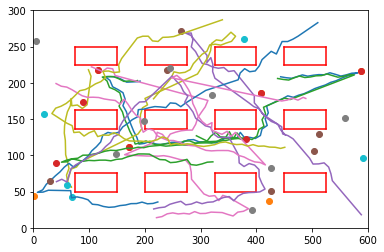

In [3]:
XG, YG, T, XB2, YB2 = man(xp,yp,xm,ym,speedmin,speedmax,d,t,0,maxtime,kolvo,Obj)
for i in range(len(Obj)): # изображение препятствий
    plt.plot([Obj[i][0],Obj[i][0]],[Obj[i][2],Obj[i][3]], 'r')
    plt.plot([Obj[i][1],Obj[i][1]],[Obj[i][2],Obj[i][3]], 'r')
    plt.plot([Obj[i][0],Obj[i][1]],[Obj[i][2],Obj[i][2]], 'r')
    plt.plot([Obj[i][0],Obj[i][1]],[Obj[i][3],Obj[i][3]], 'r')

for s in range(kolvo):
    plt.plot(XG[s],YG[s])       # траектории
    plt.plot(XB2[s],YB2[s],'o') # контрольные точки

plt.xlim([xm,xp]) # ограничения области(для вывода целиком(чтобы не приближало))
plt.ylim([ym,yp])
plt.show()

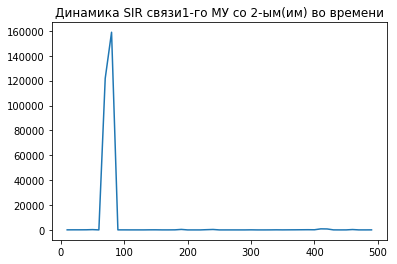


 Положение абонентов в момент максимума значения SIR(SIR=158907.872324, SIRdb=52.0114541276) связи1-го МУ со 2-ым(им)


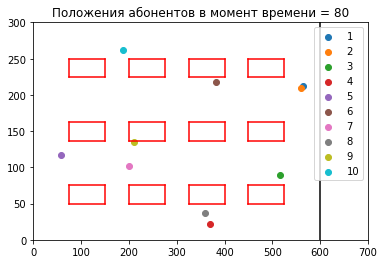


 Положение абонентов в момент минимума значения SIR(SIR=0.118752300519, SIRdb=-9.25357968288) связи1-го МУ со 2-ым(им)


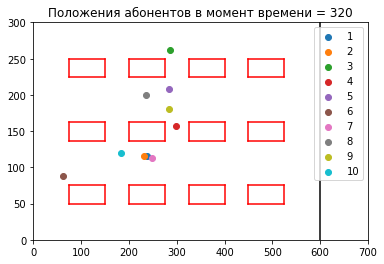

In [4]:
sumSIR = 0
forgraph1 = []
forgraph2 = []
time = t  # шаг по времени графика динамики SIR
I = 0     # номер абонента "передатчика"(номера от 0 до N-1)
J = 1     # номер абонента "приёмника"
max1 = 0
min1 = 100
while time < maxtime:
    SIR = SIRfunction(I,J,XG,YG,T,Obj,time,kolvo)
    forgraph1.append(time)
    forgraph2.append(SIR)
    if SIR > max1:
        max1 = SIR
        timeofmax = time
    if SIR < min1:
        min1 = SIR
        timeofmin = time
    sumSIR = sumSIR + SIR
    time = time + t

plt.plot(forgraph1,forgraph2)
plt.title('Динамика SIR связи'+str(I+1)+'-го МУ со '+str(J+1)+'-ым(им) во времени')
plt.show()

# положения абонентов в моменты максимума и минимума значений SIR
print('\n Положение абонентов в момент максимума значения SIR(SIR='+str(max1)+', SIRdb='+str(10*np.log10(max1))+') связи'+str(I+1)+'-го МУ со '+str(J+1)+'-ым(им)')
polojenie(XG,YG,T,timeofmax)

print('\n Положение абонентов в момент минимума значения SIR(SIR='+str(min1)+', SIRdb='+str(10*np.log10(min1))+') связи'+str(I+1)+'-го МУ со '+str(J+1)+'-ым(им)')
polojenie(XG,YG,T,timeofmin)